In [ ]:
import os,json

data_root="dataset"
def load_json(filename):
    """Load JSON file and return data."""
    with open(filename, "r") as f:
        return json.load(f)


train_data = load_json(f"{data_root}/train.json")
val_data = load_json(f"{data_root}/val.json")
test_data = load_json(f"{data_root}/test.json")


print("Sample train entry:", train_data[0])  
print("Sample val entry:", val_data[0])
print("Sample test entry:", test_data[0])

def fix_path(path):
    
    return os.path.normpath(os.path.join(data_root, path)).replace("\\", "/")

train_images = [(entry[0], fix_path(entry[1])) for entry in train_data]
val_images = [(entry[0], fix_path(entry[1])) for entry in val_data]
test_images = [(entry[0], fix_path(entry[1])) for entry in test_data]

print(f"Total train images: {len(train_images)}")
print(f"Total validation images: {len(val_images)}")
print(f"Total test images: {len(test_images)}")


Sample train entry: ['amusement', 'image/amusement/amusement_08258.jpg', 'annotation/amusement/amusement_08258.json']
Sample val entry: ['amusement', 'image/amusement/amusement_03317.jpg', 'annotation/amusement/amusement_03317.json']
Sample test entry: ['awe', 'image/awe/awe_06628.jpg', 'annotation/awe/awe_06628.json']
Total train images: 94481
Total validation images: 5905
Total test images: 17716


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
import json

from PIL import Image


class EmoSet(Dataset):
    ATTRIBUTES_MULTI_CLASS = [
        'scene', 'facial_expression', 'human_action', 'brightness', 'colorfulness',
    ]
    ATTRIBUTES_MULTI_LABEL = [
        'object'
    ]
    NUM_CLASSES = {
        'brightness': 11,
        'colorfulness': 11,
        'scene': 254,
        'object': 409,
        'facial_expression': 6,
        'human_action': 264,
    }

    def __init__(self,
                 data_root,
                 num_emotion_classes,
                 phase,
                 ):
        assert num_emotion_classes in (8, 2)
        assert phase in ('train', 'val', 'test')
        self.transforms_dict = self.get_data_transforms()

        self.info = self.get_info(data_root, num_emotion_classes)

        if phase == 'train':
            self.transform = self.transforms_dict['train']
        elif phase == 'val':
            self.transform = self.transforms_dict['val']
        elif phase == 'test':
            self.transform = self.transforms_dict['test']
        else:
            raise NotImplementedError

        data_store = json.load(open(os.path.join(data_root, f'{phase}.json')))
        self.data_store = [
            [
                self.info['emotion']['label2idx'][item[0]],
    
                os.path.join(data_root, item[1]),
                os.path.join(data_root, item[2])
            ]
            for item in data_store
        ]

    @classmethod
    def get_data_transforms(cls):
        transforms_dict = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'val': transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'test': transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
        }
        return transforms_dict

    def get_info(self, data_root, num_emotion_classes):
        assert num_emotion_classes in (8, 2)
        info = json.load(open(os.path.join(data_root, 'info.json')))
        if num_emotion_classes == 8:
            pass
        elif num_emotion_classes == 2:
            emotion_info = {
                'label2idx': {
                    'amusement': 0,
                    'awe': 0,
                    'contentment': 0,
                    'excitement': 0,
                    'anger': 1,
                    'disgust': 1,
                    'fear': 1,
                    'sadness': 1,
                },
                'idx2label': {
                    '0': 'positive',
                    '1': 'negative',
                }
            }
            info['emotion'] = emotion_info
        else:
            raise NotImplementedError

        return info

    def load_image_by_path(self, path):
        image = Image.open(path).convert('RGB')
        image = self.transform(image)
        return image

    def load_annotation_by_path(self, path):
        json_data = json.load(open(path))
        return json_data

    def __getitem__(self, item):
        emotion_label_idx, image_path, annotation_path = self.data_store[item]
        image = self.load_image_by_path(image_path)
        annotation_data = self.load_annotation_by_path(annotation_path)
        data = { 'image': image, 'emotion_label_idx': emotion_label_idx}

        for attribute in self.ATTRIBUTES_MULTI_CLASS:
            
            attribute_label_idx = -1
            if attribute in annotation_data:
                attribute_label_idx = self.info[attribute]['label2idx'][str(annotation_data[attribute])]
            data.update({f'{attribute}_label_idx': attribute_label_idx})

        for attribute in self.ATTRIBUTES_MULTI_LABEL:
           
            assert attribute == 'object'
            num_classes = self.NUM_CLASSES[attribute]
            attribute_label_idx = torch.zeros(num_classes)
            if attribute in annotation_data:
                for label in annotation_data[attribute]:
                    attribute_label_idx[self.info[attribute]['label2idx'][label]] = 1
            data.update({f'{attribute}_label_idx': attribute_label_idx})

        return data

    def __len__(self):
        return len(self.data_store)


if __name__ == '__main__':
    data_root = "dataset"
    num_emotion_classes = 8
    phase = 'train'

    dataset = EmoSet(
        data_root=data_root,
        num_emotion_classes=num_emotion_classes,
        phase=phase,
    )
    dataloader = DataLoader(dataset, batch_size = 256, shuffle = True)
    print(dataloader)
    for i,data in enumerate(dataloader):
        
        print(data['emotion_label_idx'])
        print(data['scene_label_idx'])
        print(data['facial_expression_label_idx'])
        print(data['human_action_label_idx'])
        print(data['brightness_label_idx'])
        print(data['colorfulness_label_idx'])
        print(data['object_label_idx'])
        break



tensor([3, 3, 1, 0, 4, 7, 5, 7, 5, 7, 4, 0, 3, 1, 2, 1, 0, 3, 4, 1, 1, 3, 0, 4,
        7, 0, 2, 6, 0, 2, 0, 1, 2, 6, 0, 1, 1, 0, 7, 7, 2, 5, 6, 2, 3, 7, 2, 5,
        1, 2, 1, 3, 0, 7, 1, 4, 1, 4, 1, 3, 1, 5, 2, 2, 0, 2, 6, 5, 1, 1, 2, 3,
        5, 0, 0, 7, 4, 5, 5, 7, 0, 6, 0, 2, 6, 1, 3, 2, 3, 6, 7, 0, 4, 1, 3, 5,
        6, 1, 0, 4, 7, 4, 4, 4, 3, 1, 1, 1, 7, 0, 5, 7, 6, 7, 4, 3, 6, 0, 2, 6,
        7, 7, 1, 1, 1, 0, 1, 1, 7, 4, 1, 7, 7, 5, 5, 1, 2, 6, 7, 3, 3, 6, 0, 4,
        0, 1, 4, 4, 0, 2, 6, 0, 3, 4, 4, 2, 2, 1, 3, 7, 1, 5, 0, 6, 3, 0, 2, 0,
        3, 5, 1, 3, 1, 0, 6, 6, 0, 3, 1, 0, 0, 3, 3, 0, 4, 2, 0, 4, 2, 1, 2, 0,
        1, 2, 0, 2, 3, 1, 2, 3, 3, 7, 1, 1, 7, 0, 2, 3, 0, 3, 6, 6, 1, 6, 3, 2,
        3, 4, 1, 1, 2, 5, 1, 2, 0, 7, 3, 1, 3, 3, 2, 0, 3, 6, 7, 0, 6, 4, 2, 6,
        7, 0, 0, 3, 5, 2, 1, 6, 5, 0, 4, 2, 6, 2, 0, 7])
tensor([ -1, 102, 249,  -1,  -1,  -1, 143,  -1,  -1,  -1, 233,  -1, 216, 212,
         -1,  28,   4,  -1,  -1, 155,  -1,  -1,  -1,  -1,  57,  -

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


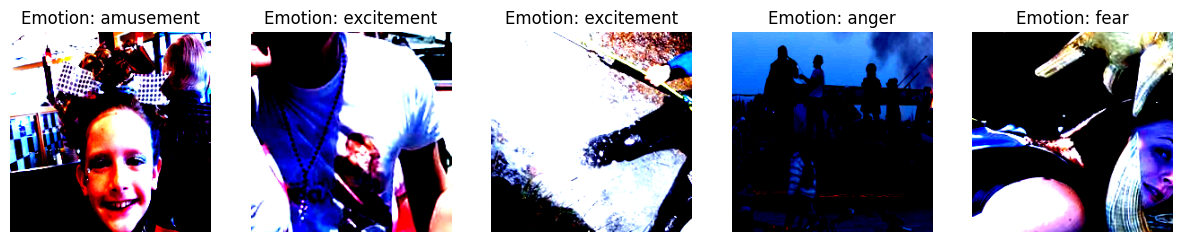

In [ ]:
import matplotlib.pyplot as plt


def visualize_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    
    for i in range(num_samples):
        data = dataset[i]  
        image = data["image"].permute(1, 2, 0).numpy()  
        emotion_idx = data["emotion_label_idx"]  
        
       
        emotion_label = dataset.info["emotion"]["idx2label"][str(emotion_idx)]
        
        axes[i].imshow(image)
        axes[i].set_title(f"Emotion: {emotion_label}")
        axes[i].axis("off")

    plt.show()


visualize_samples(dataset, num_samples=5)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

class EmotionRecognitionModel(nn.Module):
    def __init__(self, num_emotions=8, attribute_sizes=None, embedding_dim=32, hidden_dim=128):
        super(EmotionRecognitionModel, self).__init__()
        
        
        resnet = models.resnet50(pretrained=True)
        self.cnn = nn.Sequential(*list(resnet.children())[:-1])  
        self.image_fc = nn.Linear(resnet.fc.in_features, hidden_dim)
        
       
        self.attribute_nets = nn.ModuleDict()
        self.attribute_sizes = attribute_sizes
        for attr, size in attribute_sizes.items():
            if attr != 'object':  
                self.attribute_nets[attr] = nn.Sequential(
                    nn.Embedding(size + 1, embedding_dim, padding_idx=size),  
                    nn.Linear(embedding_dim, hidden_dim),
                    nn.ReLU()
                )
        
        
        self.object_fc = nn.Linear(attribute_sizes['object'], hidden_dim)
        
        
        self.fusion_fc = nn.Sequential(
            nn.Linear(hidden_dim * (len(attribute_sizes) + 1), hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        
        self.classifier = nn.Linear(hidden_dim, num_emotions)

    def forward(self, image, attributes):
        
        image_features = self.cnn(image)
        image_features = image_features.view(image_features.size(0), -1)
        image_features = self.image_fc(image_features)
        
        
        attr_features = []
        for attr, net in self.attribute_nets.items():
            
            attr_values = attributes[attr].clone()
            attr_values[attr_values == -1] = self.attribute_sizes[attr]  
            attr_features.append(net(attr_values))  
        
       
        object_features = self.object_fc(attributes['object'])
        attr_features.append(object_features)  
        
        combined_features = torch.cat([image_features] + attr_features, dim=1)
        fused_features = self.fusion_fc(combined_features)
        
     
        output = self.classifier(fused_features)
        return output




In [ ]:
def process_batch(model, batch, device):
   
    images = batch['image'].to(device)
    emotion_labels = batch['emotion_label_idx'].to(device)    
   
    attributes = {}
    
   
    for attr in ['scene', 'facial_expression', 'human_action', 'brightness', 'colorfulness']:
        attributes[attr] = batch[f'{attr}_label_idx'].to(device)
   
    attributes['object'] = batch['object_label_idx'].to(device)
    
    outputs = model(images, attributes)
    
    return outputs, emotion_labels, attributes


def train_and_validate(model, train_dataloader, valid_dataloader, criterion, optimizer, num_epochs=10, device='cuda'):
    model.to(device)
    
    
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    
    best_valid_acc = 0.0
    best_model_wts = model.state_dict()
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print('-' * 30)
        
        
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        
        print("Training...")
        for i, batch in enumerate(train_dataloader):
            try:
                optimizer.zero_grad()
                
                outputs, emotion_labels, attributes = process_batch(model, batch, device)
                loss = criterion(outputs, emotion_labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                
                
                _, predicted = torch.max(outputs.data, 1)
                total_predictions += emotion_labels.size(0)
                correct_predictions += (predicted == emotion_labels).sum().item()
                
                if i % 20 == 0:
                    batch_accuracy = 100 * (predicted == emotion_labels).sum().item() / emotion_labels.size(0)
                    print(f"Batch {i}, Loss: {loss.item():.4f}, Accuracy: {batch_accuracy:.2f}%")
                    
            except Exception as e:
                print(f"Error in training batch {i}: {e}")
               
                for attr in attributes:
                    if attr != 'object':
                        print(f"{attr} unique values: {attributes[attr].unique()}")
                continue
        
       
        train_epoch_loss = running_loss / len(train_dataloader)
        train_epoch_accuracy = 100 * correct_predictions / total_predictions
        
        train_losses.append(train_epoch_loss)
        train_accuracies.append(train_epoch_accuracy)
        
        print(f"Training - Loss: {train_epoch_loss:.4f}, Accuracy: {train_epoch_accuracy:.2f}%")
        
       
        model.eval()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        
        print("Validating...")
        with torch.no_grad():
            for i, batch in enumerate(valid_dataloader):
                try:
                    outputs, emotion_labels, attributes = process_batch(model, batch, device)
                    loss = criterion(outputs, emotion_labels)
                    
                    running_loss += loss.item()
                    
                    
                    _, predicted = torch.max(outputs.data, 1)
                    total_predictions += emotion_labels.size(0)
                    correct_predictions += (predicted == emotion_labels).sum().item()
                    
                except Exception as e:
                    print(f"Error in validation batch {i}: {e}")
                    continue
        
       
        valid_epoch_loss = running_loss / len(valid_dataloader)
        valid_epoch_accuracy = 100 * correct_predictions / total_predictions
        
        valid_losses.append(valid_epoch_loss)
        valid_accuracies.append(valid_epoch_accuracy)
        
        print(f"Validation - Loss: {valid_epoch_loss:.4f}, Accuracy: {valid_epoch_accuracy:.2f}%")
        
        
        if valid_epoch_accuracy > best_valid_acc:
            best_valid_acc = valid_epoch_accuracy
            best_model_wts = model.state_dict().copy()
            print(f"New best model saved with accuracy: {best_valid_acc:.2f}%")
    
    model.load_state_dict(best_model_wts)
    print(f"Training complete! Best validation accuracy: {best_valid_acc:.2f}%")
    
   
    history = {
        'train_loss': train_losses,
        'train_acc': train_accuracies,
        'valid_loss': valid_losses,
        'valid_acc': valid_accuracies,
        'best_acc': best_valid_acc
    }
    
    return model, history

In [ ]:


data_root = "dataset"  
num_emotion_classes = 8


attribute_sizes = {
    'scene': 254,
    'facial_expression': 6,
    'human_action': 264,
    'brightness': 11,
    'colorfulness': 11,
    'object': 409  }


train_dataset = EmoSet(data_root=data_root, num_emotion_classes=num_emotion_classes, phase='train')
valid_dataset = EmoSet(data_root=data_root, num_emotion_classes=num_emotion_classes, phase='val')
test_dataset = EmoSet(data_root=data_root, num_emotion_classes=num_emotion_classes, phase='test')

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


model = EmotionRecognitionModel(num_emotions=num_emotion_classes, attribute_sizes=attribute_sizes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")


trained_model, history = train_and_validate(
    model, 
    train_dataloader, 
    valid_dataloader, 
    criterion, 
    optimizer, 
    num_epochs=8, 
    device=device
)






torch.save({
    'model_state_dict': trained_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'attribute_sizes': attribute_sizes,
    'num_emotions': num_emotion_classes,
    'history': history,
}, 'emotion_recognition_model.pth')

print("Model saved successfully!")

c:\Users\Tanaz\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Tanaz\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cuda

Epoch 1/8
------------------------------
Training...
Batch 0, Loss: 2.0865, Accuracy: 12.50%


KeyboardInterrupt: 

In [5]:
!pip install timm



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import torch
import torch.nn as nn
import timm  
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

class EmotionRecognitionModel(nn.Module):
    def __init__(self, num_emotions=8, attribute_sizes=None, embedding_dim=32, hidden_dim=128):
        super(EmotionRecognitionModel, self).__init__()
        
        
        self.swin = timm.create_model("swin_tiny_patch4_window7_224", pretrained=True, num_classes=0)
        swin_feature_dim = self.swin.num_features  # Feature size from Swin
        
        self.image_fc = nn.Linear(swin_feature_dim, hidden_dim)

      
        self.attribute_nets = nn.ModuleDict()
        self.attribute_sizes = attribute_sizes
        for attr, size in attribute_sizes.items():
            if attr != 'object':  
                self.attribute_nets[attr] = nn.Sequential(
                    nn.Embedding(size + 1, embedding_dim, padding_idx=size),  # Handle missing values
                    nn.Linear(embedding_dim, hidden_dim),
                    nn.ReLU()
                )
        
       
        self.object_fc = nn.Linear(attribute_sizes['object'], hidden_dim)
        
     
        self.fusion_fc = nn.Sequential(
            nn.Linear(hidden_dim * (len(attribute_sizes) + 1), hidden_dim),  
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
       
        self.classifier = nn.Linear(hidden_dim, num_emotions)

    def forward(self, image, attributes):
      
        image_features = self.swin(image)
        image_features = self.image_fc(image_features)

        
        attr_features = []
        for attr, net in self.attribute_nets.items():
            attr_values = attributes[attr].clone()
            attr_values[attr_values == -1] = self.attribute_sizes[attr]  # Handle missing values
            attr_features.append(net(attr_values))  
        
       
        object_features = self.object_fc(attributes['object'])
        attr_features.append(object_features)
        
       
        combined_features = torch.cat([image_features] + attr_features, dim=1)
        fused_features = self.fusion_fc(combined_features)
        
        
        output = self.classifier(fused_features)
        return output


In [ ]:
import os
def process_batch(model, batch, device):
   
    images = batch['image'].to(device)
    emotion_labels = batch['emotion_label_idx'].to(device)

    attributes = {}
    
 
    for attr in ['scene', 'facial_expression', 'human_action', 'brightness', 'colorfulness']:
        attributes[attr] = batch[f'{attr}_label_idx'].to(device)
    
    
    attributes['object'] = batch['object_label_idx'].to(device)
    
    
    outputs = model(images, attributes)
    
    return outputs, emotion_labels, attributes
def train_and_validate(model, train_dataloader, valid_dataloader, criterion, optimizer, num_epochs=10, device='cuda', save_path="saved_models"):
    model.to(device)
    
    
    os.makedirs(save_path, exist_ok=True)

    
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    
    best_valid_acc = 0.0
    best_model_wts = model.state_dict()

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print('-' * 30)
        
       
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        
        print("Training...")
        for i, batch in enumerate(train_dataloader):
            try:
                optimizer.zero_grad()
                
                outputs, emotion_labels, attributes = process_batch(model, batch, device)
                loss = criterion(outputs, emotion_labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                
                
                _, predicted = torch.max(outputs.data, 1)
                total_predictions += emotion_labels.size(0)
                correct_predictions += (predicted == emotion_labels).sum().item()
                
                if i % 20 == 0:
                    batch_accuracy = 100 * (predicted == emotion_labels).sum().item() / emotion_labels.size(0)
                    print(f"Batch {i}, Loss: {loss.item():.4f}, Accuracy: {batch_accuracy:.2f}%")
                    
            except Exception as e:
                print(f"Error in training batch {i}: {e}")
                continue
        
        
        train_epoch_loss = running_loss / len(train_dataloader)
        train_epoch_accuracy = 100 * correct_predictions / total_predictions
        
        train_losses.append(train_epoch_loss)
        train_accuracies.append(train_epoch_accuracy)
        
        print(f"Training - Loss: {train_epoch_loss:.4f}, Accuracy: {train_epoch_accuracy:.2f}%")
        
      
        model.eval()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        
        print("Validating...")
        with torch.no_grad():
            for i, batch in enumerate(valid_dataloader):
                try:
                    outputs, emotion_labels, attributes = process_batch(model, batch, device)
                    loss = criterion(outputs, emotion_labels)
                    
                    running_loss += loss.item()
                    
                    
                    _, predicted = torch.max(outputs.data, 1)
                    total_predictions += emotion_labels.size(0)
                    correct_predictions += (predicted == emotion_labels).sum().item()
                    
                except Exception as e:
                    print(f"Error in validation batch {i}: {e}")
                    continue
        
       
        valid_epoch_loss = running_loss / len(valid_dataloader)
        valid_epoch_accuracy = 100 * correct_predictions / total_predictions
        
        valid_losses.append(valid_epoch_loss)
        valid_accuracies.append(valid_epoch_accuracy)
        
        print(f"Validation - Loss: {valid_epoch_loss:.4f}, Accuracy: {valid_epoch_accuracy:.2f}%")
        
        
        model_filename = os.path.join(save_path, f"emotion_recognition_epoch_{epoch+1}.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'attribute_sizes': model.attribute_sizes,
            'num_emotions': model.classifier.out_features,
            'history': {
                'train_loss': train_losses,
                'train_acc': train_accuracies,
                'valid_loss': valid_losses,
                'valid_acc': valid_accuracies,
            }
        }, model_filename)
        
        print(f"Model saved: {model_filename}")
        
        
        if valid_epoch_accuracy > best_valid_acc:
            best_valid_acc = valid_epoch_accuracy
            best_model_wts = model.state_dict().copy()
            best_model_filename = os.path.join(save_path, "best_emotion_recognition.pth")
            torch.save({
                'model_state_dict': best_model_wts,
                'optimizer_state_dict': optimizer.state_dict(),
                'best_acc': best_valid_acc,
            }, best_model_filename)
            print(f"Best model updated with accuracy: {best_valid_acc:.2f}%")
    
  
    model.load_state_dict(best_model_wts)
    print(f"Training complete! Best validation accuracy: {best_valid_acc:.2f}%")
    
    
    history = {
        'train_loss': train_losses,
        'train_acc': train_accuracies,
        'valid_loss': valid_losses,
        'valid_acc': valid_accuracies,
        'best_acc': best_valid_acc
    }
    
    return model, history


In [ ]:


data_root = "dataset"  
num_emotion_classes = 8


attribute_sizes = {
    'scene': 254,
    'facial_expression': 6,
    'human_action': 264,
    'brightness': 11,
    'colorfulness': 11,
    'object': 409  
}


train_dataset = EmoSet(data_root=data_root, num_emotion_classes=num_emotion_classes, phase='train')
valid_dataset = EmoSet(data_root=data_root, num_emotion_classes=num_emotion_classes, phase='val')
test_dataset = EmoSet(data_root=data_root, num_emotion_classes=num_emotion_classes, phase='test')

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


model = EmotionRecognitionModel(num_emotions=num_emotion_classes, attribute_sizes=attribute_sizes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")


trained_model, history = train_and_validate(
    model, 
    train_dataloader, 
    valid_dataloader, 
    criterion, 
    optimizer, 
    num_epochs=8, 
    device=device
)



torch.save({
    'model_state_dict': trained_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'attribute_sizes': attribute_sizes,
    'num_emotions': num_emotion_classes,
    'history': history,
}, 'emotion_recognition_model.pth')

print("Model saved successfully!")

Using device: cuda

Epoch 1/8
------------------------------
Training...
Batch 0, Loss: 2.0600, Accuracy: 18.75%
Batch 20, Loss: 1.9596, Accuracy: 18.75%
Batch 40, Loss: 1.6144, Accuracy: 40.62%
Batch 60, Loss: 1.7364, Accuracy: 31.25%
Batch 80, Loss: 1.5471, Accuracy: 37.50%
Batch 100, Loss: 1.2857, Accuracy: 53.12%
Batch 120, Loss: 1.4527, Accuracy: 46.88%
Batch 140, Loss: 1.6358, Accuracy: 53.12%
Batch 160, Loss: 1.3784, Accuracy: 50.00%
Batch 180, Loss: 1.1748, Accuracy: 59.38%
Batch 200, Loss: 1.4446, Accuracy: 46.88%
Batch 220, Loss: 1.4229, Accuracy: 37.50%
Batch 240, Loss: 1.5849, Accuracy: 43.75%
Batch 260, Loss: 1.0922, Accuracy: 62.50%
Batch 280, Loss: 1.6061, Accuracy: 46.88%
Batch 300, Loss: 1.3843, Accuracy: 46.88%
Batch 320, Loss: 1.5772, Accuracy: 40.62%
Batch 340, Loss: 1.3740, Accuracy: 43.75%
Batch 360, Loss: 1.5698, Accuracy: 37.50%
Batch 380, Loss: 1.6441, Accuracy: 40.62%
Batch 400, Loss: 1.0435, Accuracy: 65.62%
Batch 420, Loss: 1.5090, Accuracy: 40.62%
Batch 440

In [12]:
def plot_training_history(history):
    """Plot training and validation metrics"""
    plt.figure(figsize=(12, 5))
    
    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['valid_acc'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['valid_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()
# Plot training history
plot_training_history(history)

NameError: name 'history' is not defined

In [ ]:
def evaluate_model(model, dataloader, criterion, device='cuda', idx2label=None):
    """Evaluate the model and print detailed metrics"""
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            try:
                outputs, emotion_labels, _ = process_batch(model, batch, device)
                loss = criterion(outputs, emotion_labels)
                
                running_loss += loss.item()
                
                # Get predictions
                _, predicted = torch.max(outputs.data, 1)
                
                # Collect labels and predictions for metrics
                all_labels.extend(emotion_labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                
            except Exception as e:
                print(f"Error in evaluation batch {i}: {e}")
                continue
    
    # Calculate metrics
    test_loss = running_loss / len(dataloader)
    test_accuracy = 100 * sum(1 for pred, label in zip(all_predictions, all_labels) if pred == label) / len(all_labels)
    
    print(f"\nEvaluation Results:")
    print(f"Loss: {test_loss:.4f}")
    print(f"Accuracy: {test_accuracy:.2f}%")
    
    # Generate and print confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Generate detailed classification report
    print("\nClassification Report:")
    if idx2label:
        target_names = [idx2label[str(i)] for i in range(len(idx2label))]
        print(classification_report(all_labels, all_predictions, target_names=target_names))
    else:
        print(classification_report(all_labels, all_predictions))
    
    return test_loss, test_accuracy, cm, all_labels, all_predictions
print("\nEvaluating on test set...")
emotion_idx2label = train_dataset.info['emotion']['idx2label']
test_loss, test_acc, conf_matrix, _, _ = evaluate_model(
    trained_model, 
    test_dataloader, 
    criterion, 
    device=device, 
    idx2label=emotion_idx2label
)
print(f"Test Accuracy: {test_acc:.2f}%")